In [1]:
import os
import numpy as np
import scipy
import matplotlib
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
%matplotlib inline

### ~~ CONSTANTS AND DATA ~~ ###

meas_time = 20.
T_SNSPD = 30.
reps = 30
reps_SNSPD = 20

syml_th = -4
plt.rcParams['hatch.linewidth'] = 2

In [2]:
def symlog_ytick(x, pos):
    if x == 0:
        return f'$\pm 10^{{{syml_th}}}$'
    lx = int(np.log10(abs(x)))
    if x < 0:
        pre = '-'
    else:
        pre = ''
    if lx > syml_th:
        return f'${pre}10^{{{lx}}}$'
    else:
        return None

# SPAD data

In [3]:
dat = np.genfromtxt('COUNT.txt', encoding='utf-8-sig')
dat = np.array(np.split(dat, len(dat)/reps))

In [4]:
delta_raw = (dat[:,:,0]+dat[:,:,1])/dat[:,:,2]-1.

rate_means = np.mean(dat[:,:,2]/meas_time, axis=1)*1e-6
delta_means = np.mean(delta_raw, axis=1)
delta_errs = np.std(delta_raw, axis=1, ddof=1)/np.sqrt(reps) # standard error of the mean

# Settling efficiency model

$\eta(t)$ is efficiency as a function of time since the end of the previous dead time. Then the mean time $\langle \Delta t \rangle$ (between the end of dead time and the next detection) is:

\begin{align}
H(t) &= \int_0^t \eta(t') dt' \\
\langle \Delta t \rangle &= \int_0^\infty t \times \lambda \eta(t) e^{-\lambda H(t)} dt = \int_0^\infty e^{-\lambda H(t)} dt
\end{align}

For a negative exponential $$\eta(t) = 1 + \delta \exp(-\gamma t)$$ the primitive function is $$H(t) = t + \frac{\delta}{\gamma}\big( 1-\exp(-\gamma t) \big)$$

In [5]:
def Eta(t, d, g): # efficiency
    return 1+d*np.exp(-g*t)
def H(t, d, g): # integrated efficiency
    return t+d/g*(1-np.exp(-g*t))
def Integ(t, m, d, g): # integration term for the mean delay
    return np.exp(-m*(t+d/g*(1-np.exp(-g*t))))
def MeanDelay(m, d, g):
    return quad(Integ, 0, 1/m*100, args=(m, d, g))
def MeanRate(flux, dc, tau, d, g):
    return 1./(MeanDelay(flux+dc, d, g)[0] + tau)
def DeltaDataPoint(flux, dc, tau, d, g):
    return (
            MeanRate(flux, dc, tau, d, g),
             2*MeanRate(flux/2, dc, tau, d, g)/\
               MeanRate(flux, dc, tau, d, g) - 1
           );

In [6]:
## fit values taken from the ordinary model
dc=1.7476e-05
tau=0.06104589

# parameters that provide a good match
d=0.025
g=0.015

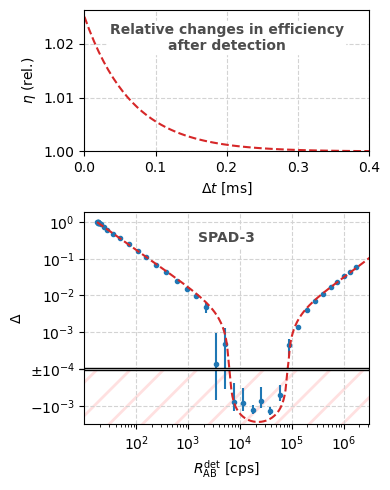

In [7]:
def PlotSPAD3():
    
    tit = "SPAD-3"
    
    bigfontsize = 10
    pcolor = 'tab:blue' # plot points
    mcolor = 'tab:red'  # model curve

    fig = plt.figure(figsize=(4,5))
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[2,3])
    
    # EFFICIENCY
    
    ax1 = fig.add_subplot(gs[0])
    
    x = np.linspace(0, 10./g, 100)
    ax1.plot(x*1e-3, Eta(x, d, g), color='tab:red', ls='--')
    
    ax1.set_xlim(left=0, right=0.4)
    ax1.set_ylim(bottom=1)

    ax1.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
    
    ax1.set_xlabel(r'$\Delta t$ [ms]')
    ax1.set_ylabel(r'$\eta$ (rel.)')
    
    ax1.annotate('Relative changes in efficiency\nafter detection', xy=(0.5, 0.91), xycoords='axes fraction',
                 ha='center', va='top', fontsize=bigfontsize, weight='bold', c='0.3',
                 bbox=dict(color='w', boxstyle=('square, pad=0.1')))
    
    # NONLINEARITY
    
    ax2 = fig.add_subplot(gs[1])
    
    ax2.set_xscale('log')

    ax2.set_yscale('symlog', linthresh=10**syml_th, linscale=0.001)
    ax2.yaxis.set_major_formatter(FuncFormatter(symlog_ytick))

    ax2.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
    ax2.set_axisbelow(True)

    ax2.errorbar(rate_means*1e6, delta_means, yerr=delta_errs, fmt='o', markersize=3., zorder=1, color=pcolor)

    ax2.set_xlim(ax2.get_xlim())
    ax2.set_ylim(top=ax2.get_ylim()[1])

    mu = np.logspace(-7, 3, 500)
    nlp = np.vectorize(DeltaDataPoint)(mu, dc=dc,  tau=tau, d=d, g=g)
    nlp = np.array(nlp)
    nlp[0] = nlp[0]*1e6
    ax2.plot(*nlp, color=mcolor, ls='--', zorder=3)

    ax2.set_xlabel(r'$R^{\mathrm{det}}_{\mathrm{AB}}$ [cps]')
    ax2.set_ylabel(r'$\Delta$')

    ax2.annotate(tit, xy=(0.5, 0.91), xycoords='axes fraction', ha='center', va='top',
                fontsize=bigfontsize, weight='bold', c='0.3',
                bbox=dict(color='w', boxstyle=('square, pad=0.1')))


    fig.tight_layout(pad=0, h_pad=0.6, w_pad=0.6)

    xb = ax2.get_xlim()
    yb = ax2.get_ylim()

    axes_break = patches.Rectangle((xb[0], -1.04e-4), xb[1]-xb[0],
                           2.08e-4, fc='w', ec='k', zorder = 3)
    ax2.add_patch(axes_break)
    neg_hatches = patches.Rectangle((xb[0], yb[0]), xb[1]-xb[0],
                           0-yb[0], fc='w', ec='#ffe0e0', lw=0, hatch='/', zorder = 0)
    ax2.add_patch(neg_hatches)
    
    plt.tight_layout()

    plt.show()
    
    return fig

fig_SPAD3 = PlotSPAD3()

# Interarrival histogram

In [8]:
# IA histogram where 1 bin = 1 μs
iahist = np.loadtxt('SPAD-3_IA_hist_10k-rate_1us-window.txt')
# estimated count rate per μs that determines the exponential slope of the interarrival distribution
est_rate = 0.0102377

In [9]:
def HistModel(t, lam, d, g):
    return lam*Eta(t, d, g)*np.exp(-lam*H(t, d, g))

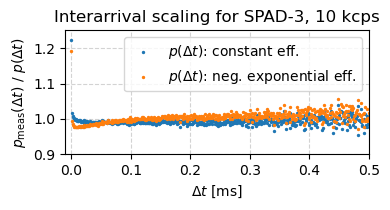

In [10]:
def PlotHistRel():
    
    fig = plt.figure(figsize=(4,2.2))
    
    # switch time unit to ms on the x-axis
    time_unit = 1e3
    
    x = np.arange(0., iahist.size, 1.)

    # constanty efficiency - negative exponential
    model1 = np.sum(iahist)*est_rate*np.exp(-est_rate*x)
    # settling efficiency
    model2 = np.sum(iahist)*HistModel(x, est_rate, d, g)
    
    plt.scatter(x/time_unit, iahist/model1, s=2., zorder=2, label='$p(\Delta t)$: constant eff.')
    plt.scatter(x/time_unit, iahist/model2, s=2., zorder=2, label='$p(\Delta t)$: neg. exponential eff.')
    
    plt.xlim(left=-0.01, right=0.5)
    plt.ylim(bottom=0.9,top=1.25)
    
    plt.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
    
    plt.xlabel('$\Delta t$ [ms]')
    plt.ylabel('$p_\mathrm{meas}(\Delta t)\ /\ p(\Delta t)$')
    
    plt.title('Interarrival scaling for SPAD-3, 10 kcps')
    
    plt.legend()
    
    plt.tight_layout()
    
    plt.show()
    
    return fig
    
fig_histRel = PlotHistRel()